In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
# Set style for nice charts
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Define Tickers
tickers = ['BTC-USD', 'QQQ']

# 2. Download Data (Last 5 Years)
print("Fetching data...")
data = yf.download(tickers, period="5y", interval="1d")

# 3. Clean Data: We only want the 'Close' price
# Note: yfinance returns a MultiIndex, we simplify it
df = data['Close'].copy()
df.dropna(inplace=True)

print(df.head())

Fetching data...


[*********************100%***********************]  2 of 2 completed

Ticker           BTC-USD         QQQ
Date                                
2020-12-07  19191.630859  298.008057
2020-12-08  18321.144531  299.016785
2020-12-09  18553.916016  292.246704
2020-12-10  18264.992188  293.420380
2020-12-11  18058.904297  292.770508


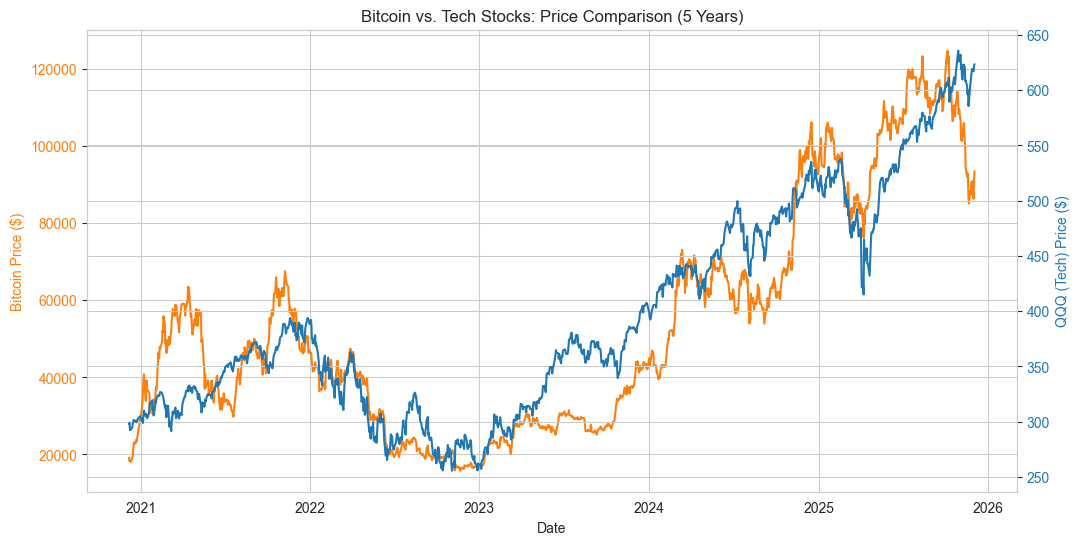

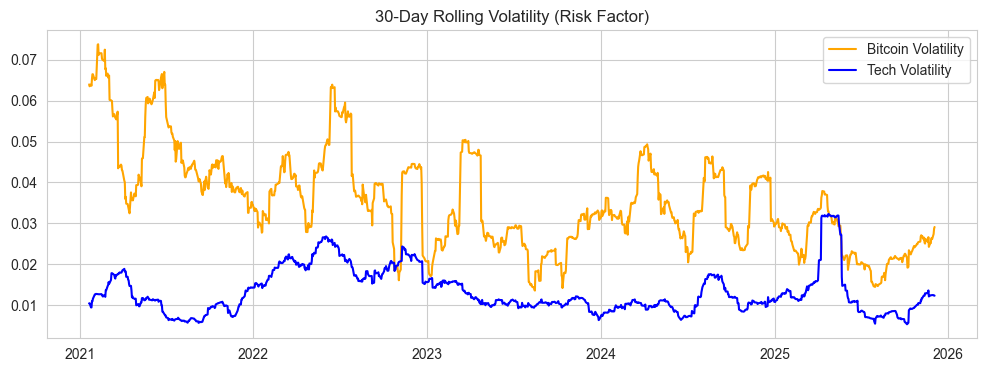

In [15]:
# --- CELL 2: VISUALIZATION ---

# 1. Calculate Daily Returns (%)
returns = df.pct_change().dropna()

# 2. Calculate Rolling Volatility (30-day window)
# This shows "Risk" over time
volatility = returns.rolling(window=30).std()

# --- CHART 1: Price Comparison (Dual Axis) ---
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price ($)', color=color)
ax1.plot(df.index, df['BTC-USD'], color=color, label='Bitcoin')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('QQQ (Tech) Price ($)', color=color)
ax2.plot(df.index, df['QQQ'], color=color, label='QQQ (Tech)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Bitcoin vs. Tech Stocks: Price Comparison (5 Years)')
plt.show()

# --- CHART 2: Volatility (Risk) ---
plt.figure(figsize=(12, 4))
plt.plot(volatility.index, volatility['BTC-USD'], label='Bitcoin Volatility', color='orange')
plt.plot(volatility.index, volatility['QQQ'], label='Tech Volatility', color='blue')
plt.title('30-Day Rolling Volatility (Risk Factor)')
plt.legend()
plt.show()

Model Accuracy: 0.4857142857142857

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.58      0.53       123
           1       0.48      0.39      0.43       122

    accuracy                           0.49       245
   macro avg       0.48      0.49      0.48       245
weighted avg       0.48      0.49      0.48       245



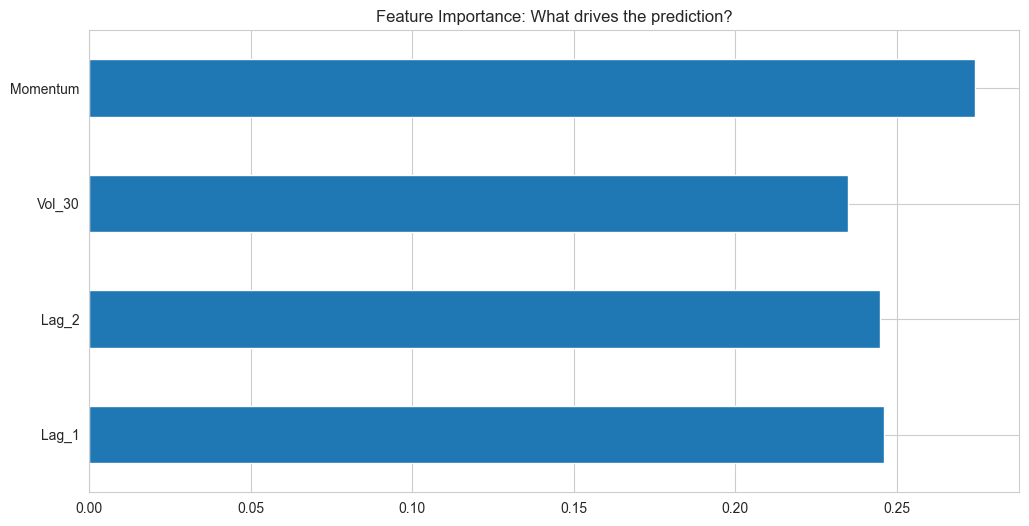

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Feature Engineering for Bitcoin
# We want to predict if BTC closes UP tomorrow (1) or DOWN (0)
btc_df = pd.DataFrame(df['BTC-USD']).rename(columns={'BTC-USD': 'Close'})

# Create Features based on past data
btc_df['Return'] = btc_df['Close'].pct_change()
btc_df['Lag_1'] = btc_df['Return'].shift(1)  # Yesterday's return
btc_df['Lag_2'] = btc_df['Return'].shift(2)  # 2 days ago
btc_df['Vol_30'] = btc_df['Return'].rolling(30).std() # 30-day Volatility
btc_df['Momentum'] = btc_df['Close'] / btc_df['Close'].shift(10) # Price vs 10 days ago

# Create Target: 1 if tomorrow's price is higher than today's
btc_df['Target'] = (btc_df['Close'].shift(-1) > btc_df['Close']).astype(int)

# Drop NaNs created by shifting/rolling
btc_df.dropna(inplace=True)

# 2. Split Data (Train on first 80%, Test on recent 20%)
# Note: For time series, we DO NOT shuffle. We split chronologically.
features = ['Lag_1', 'Lag_2', 'Vol_30', 'Momentum']
X = btc_df[features]
y = btc_df['Target']

split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 3. Train Model
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)

# 4. Evaluate
predictions = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

# 5. Feature Importance Visualization
# This tells us WHICH data point matters most for prediction
importances = pd.Series(model.feature_importances_, index=features)
importances.plot(kind='barh', title='Feature Importance: What drives the prediction?')
plt.show()